In [1]:
#!/usr/bin/env python

# RO_evaluation.ipynb

In [2]:
''' 
   RO_evaluation.ipynb

   This program first reads in preprocessd data from the following programs:
   
   projects/2020_CONUS404/programs/WRF_RO-data-processing/WRF_RO-data-processing.ipynb
   projects/2020_CONUS404/programs/RS_evaluation/IGRA-soundings-preprocessor.ipynb
   projects/2020_CONUS404/programs/RS_evaluation/UWY-soundings-preprocessor.ipynb
   projects/2020_CONUS404/programs/ERA5_RO-data-processing/ERA5_RO-data-processing.py
   
   It collects data from RO soundings and CONUS404 and ERA5 soundings at the same time
   
   The data is used to investigate changes in sounding data and how they are related to precipitation changes

'''

' \n   RO_evaluation.ipynb\n\n   This program first reads in preprocessd data from the following programs:\n   \n   projects/2020_CONUS404/programs/WRF_RO-data-processing/WRF_RO-data-processing.ipynb\n   projects/2020_CONUS404/programs/RS_evaluation/IGRA-soundings-preprocessor.ipynb\n   projects/2020_CONUS404/programs/RS_evaluation/UWY-soundings-preprocessor.ipynb\n   projects/2020_CONUS404/programs/ERA5_RO-data-processing/ERA5_RO-data-processing.py\n   \n   It collects data from RO soundings and CONUS404 and ERA5 soundings at the same time\n   \n   The data is used to investigate changes in sounding data and how they are related to precipitation changes\n\n'

In [3]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import glob
import os
from pdb import set_trace as stop
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import median_filter
from scipy.ndimage import label
from matplotlib import cm
from scipy import ndimage
import random
import scipy
import pickle
import datetime
import pandas as pd
import subprocess
from calendar import monthrange
import pandas as pd
import datetime
import sys 
import shapefile as shp
import matplotlib.path as mplPath
from scipy.stats import norm
import matplotlib.gridspec as gridspec
# from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile
from calendar import monthrange
import metpy
from scipy.interpolate import interp1d
import metpy.calc as mpcalc
from metpy.units import units
import wrf
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

###  USER MODIFY SECTION

In [4]:
dStartDayPR=datetime.datetime(1980, 1, 1,0)
dStopDayPR=datetime.datetime(2019, 12, 31,12)
rgdTime = pd.date_range(dStartDayPR, end=dStopDayPR, freq='h')
rgdTime12h = pd.date_range(dStartDayPR, end=dStopDayPR, freq='12h')
rgdTimeDD = pd.date_range(dStartDayPR, end=dStopDayPR, freq='d')
rgdTimeMM = pd.date_range(dStartDayPR, end=dStopDayPR, freq='m')
Years = np.unique(rgdTime.year)

min_complete = 0.8 # minimum fraction of data that has to be available for processing

UWYdir = '/glade/campaign/mmm/c3we/prein/observations/RadioSoundings_Uni-Wyoming/data_com-z-coordinate/'
IGRAMdir = '/glade/campaign/mmm/c3we/prein/observations/RadioSoundings_IGRAv2/data_com-z-coordinate/'
WRFdir = '/glade/campaign/mmm/c3we/prein/CONUS404/data/RO_Analysis/'
ERA5dir = '/glade/campaign/mmm/c3we/prein/CONUS404/data/RO_Analysis/'

SaveDir = '/glade/campaign/mmm/c3we/prein/CONUS404/data/RO_Analysis/'
SaveFolder = '/glade/campaign/mmm/c3we/prein/CONUS404/data/CONUS404_processed_data/'
Seasons = ['DJF','MAM','JJA','SON']

### Load some basic setups

In [5]:
# load a single file to get the numbre of RS locations
DATA = np.load(WRFdir+'1979-10_RO_soundings-on-com-grid.npz')
Lon = DATA['WRF_RS_Lon']
Lat = DATA['WRF_RS_Lat']
WRF_RS_loc = DATA['WRF_RS_loc']
Zcoord = DATA['VertCoord']
VARS = list(DATA['rgsSondVars'])
VARS = VARS+['U','V']
RS_Source = DATA['WRF_RS_source']
StationIDs = list(DATA['StationIDs'])

LatLon = np.array([str(Lat[ll])+','+str(Lon[ll]) for ll in range(len(Lon))])

# get elevation of grid cells with soundings
ncid=Dataset('/glade/campaign/ncar/USGS_Water/CONUS404/wrfconstants_d01_1979-10-01_00:00:00.nc4', mode='r')
WRF_height=np.squeeze(ncid.variables['HGT'][:])
ncid.close()
RS_Elevation_WRF = WRF_height[WRF_RS_loc[:,0],WRF_RS_loc[:,1]]

# Created the common matrixes
DATASETS = ['Radiosonde_Sounding','CONUS404', 'ERA5']
RS_data = np.zeros((len(rgdTime12h),len(Zcoord),len(Lat),len(VARS),len(DATASETS))); RS_data[:] = np.nan

### Load the UWY data

In [6]:
UW_stations = (RS_Source == 'UWY')
UW_IDS = np.array(StationIDs)[UW_stations]
for st in range(len(UW_IDS)):
    ActFile = UWYdir+UW_IDS[st]+'_data-on-common-Zlev_1979-2021.npz'
    DATA = np.load(ActFile)
    UW_VARS = list(DATA['rgsSondVars'])
    timeACT = pd.to_datetime(DATA['rgdTime'])
    FocTime = np.isin(timeACT, rgdTime12h)
    
    UW_RSdata = DATA['rgrProfiles'][FocTime,:,:]
    # save the data to the common matrix
    RS_data[:,:,st,VARS.index('P'),0] = UW_RSdata[:,:,UW_VARS.index('P')] # in hPa
    RS_data[:,:,st,VARS.index('Z'),0] = UW_RSdata[:,:,UW_VARS.index('Z')] # in m
    RS_data[:,:,st,VARS.index('T'),0] = UW_RSdata[:,:,UW_VARS.index('T')] # in deg C
    RS_data[:,:,st,VARS.index('MR'),0] = UW_RSdata[:,:,UW_VARS.index('MR')] # in deg kg/kg
    RS_data[:,:,st,VARS.index('WDIR'),0] = UW_RSdata[:,:,UW_VARS.index('WDIR')] # in deg
    RS_data[:,:,st,VARS.index('WSPD'),0] = UW_RSdata[:,:,UW_VARS.index('WSPD')] # in m/s
    
    # Add the wind directions to the 
    speed = RS_data[:,:,st,VARS.index('WSPD'),0] * units('m/s')
    wind_direction = RS_data[:,:,st,VARS.index('WDIR'),0] * units('degree')
    UU,VV = metpy.calc.wind_components(speed, wind_direction)
    RS_data[:,:,st,VARS.index('U'),0] = UU # in m/s
    RS_data[:,:,st,VARS.index('V'),0] = VV # in m/s
    

### Load the IGRAM data

In [7]:
IGRAM_stations = (RS_Source == 'IGRAM')
IGRAM_IDS = np.array(StationIDs)[IGRAM_stations]
for st in range(len(IGRAM_IDS)):
    ActFile = IGRAMdir+IGRAM_IDS[st]+'_data-on-common-Zlev.npz'
    DATA = np.load(ActFile)
    IGRAM_VARS = list(DATA['rgsSondVars'])
    timeACT = pd.to_datetime(DATA['rgdTime'])
    FocTime = np.isin(timeACT, rgdTime12h)
    
    IGRAM_RSdata = DATA['rgrProfiles'][FocTime,:,:]
    # save the data to the common matrix
    RS_data[:,:,StationIDs.index(IGRAM_IDS[st]),VARS.index('P'),0] = IGRAM_RSdata[:,:,IGRAM_VARS.index('P')]/100. # in hPa
    RS_data[:,:,StationIDs.index(IGRAM_IDS[st]),VARS.index('Z'),0] = IGRAM_RSdata[:,:,IGRAM_VARS.index('Z')] # in m
    RS_data[:,:,StationIDs.index(IGRAM_IDS[st]),VARS.index('T'),0] = IGRAM_RSdata[:,:,IGRAM_VARS.index('T')] # in deg C
    RS_data[:,:,StationIDs.index(IGRAM_IDS[st]),VARS.index('WDIR'),0] = IGRAM_RSdata[:,:,IGRAM_VARS.index('WDIR')] # in deg
    RS_data[:,:,StationIDs.index(IGRAM_IDS[st]),VARS.index('WSPD'),0] = IGRAM_RSdata[:,:,IGRAM_VARS.index('WSPD')] # in m/s
    
    # calculate mixing ratio
    TD = IGRAM_RSdata[:,:,IGRAM_VARS.index('T')] - IGRAM_RSdata[:,:,IGRAM_VARS.index('DPD')]
    TD = TD * units('celsius')
    TA = IGRAM_RSdata[:,:,IGRAM_VARS.index('T')] * units('celsius')
    RH = metpy.calc.relative_humidity_from_dewpoint(TA, TD)
    PP = IGRAM_RSdata[:,:,IGRAM_VARS.index('P')] * units('pascal')
    MR = np.array(metpy.calc.mixing_ratio_from_relative_humidity(RH, TA, PP))
    RS_data[:,:,StationIDs.index(IGRAM_IDS[st]),VARS.index('MR'),0] = MR # in deg kg/kg
    
    # Add the wind directions
    speed = RS_data[:,:,st,VARS.index('WSPD'),0] * units('m/s')
    wind_direction = RS_data[:,:,st,VARS.index('WDIR'),0] * units('degree')
    UU,VV = metpy.calc.wind_components(speed, wind_direction)
    RS_data[:,:,st,VARS.index('U'),0] = UU # in m/s
    RS_data[:,:,st,VARS.index('V'),0] = VV # in m/s

### Load WRF data

In [8]:
for mm in range(len(rgdTimeMM)):
    YYYY = str(rgdTimeMM[mm].year)
    MM = str(rgdTimeMM[mm].month).zfill(2)
    WRF_filenameACT = WRFdir+YYYY+'-'+MM+'_RO_soundings-on-com-grid.npz'
    DATA = np.load(WRF_filenameACT)
    timeACT = pd.to_datetime(DATA['Time'])
    FocTime = np.isin(rgdTime12h,timeACT)
    RS_data[FocTime,:,:,:6,1] = np.moveaxis(DATA['WRF_RS'],2,1)
    RS_data[FocTime,:,:,VARS.index('T'),1] = RS_data[FocTime,:,:,VARS.index('T'),1]-273.15
    RS_data[FocTime,:,:,VARS.index('P'),1] = RS_data[FocTime,:,:,VARS.index('P'),1]/100.
    RS_data[FocTime,:,:,VARS.index('MR'),1] = RS_data[FocTime,:,:,VARS.index('MR'),1]

    # Add the wind directions
    speed = RS_data[FocTime,:,:,VARS.index('WSPD'),1] * units('m/s')
    wind_direction = RS_data[FocTime,:,:,VARS.index('WDIR'),1] * units('degree')
    UU,VV = metpy.calc.wind_components(speed, wind_direction)
    RS_data[FocTime,:,:,VARS.index('U'),1] = np.array(UU) # in m/s
    RS_data[FocTime,:,:,VARS.index('V'),1] = np.array(VV) # in m/s
    
# replace vertical coordinate with common grid
RS_data[:,:,:,VARS.index('Z'),1] = RS_data[:,:,:,VARS.index('Z'),0]

### Load the ERA5 data

In [9]:
# for mm in range(len(rgdTimeMM)):
#     YYYY = str(rgdTimeMM[mm].year)
#     MM = str(rgdTimeMM[mm].month).zfill(2)
#     ERA5_filenameACT = ERA5dir+YYYY+'-'+MM+'_ERA5_RO_soundings-on-com-grid.npz'
#     DATA = np.load(ERA5_filenameACT)
#     timeACT = pd.to_datetime(DATA['Time'])
#     FocTime = np.isin(rgdTime12h,timeACT)
#     ERA_RS = DATA['ERA5_RS']
#     ERA_RS = np.reshape(ERA_RS, (ERA_RS.shape[0]*ERA_RS.shape[1],ERA_RS.shape[2],ERA_RS.shape[3],ERA_RS.shape[4]))
#     RS_data[FocTime,:,:,:6,2] = np.moveaxis(ERA_RS,2,1)
#     RS_data[FocTime,:,:,VARS.index('T'),2] = RS_data[FocTime,:,:,VARS.index('T'),2]-273.15
#     RS_data[FocTime,:,:,VARS.index('MR'),2] = RS_data[FocTime,:,:,VARS.index('MR'),2]*1000.
# #     RS_data[FocTime,:,:,VARS.index('P'),2] = RS_data[FocTime,:,:,VARS.index('P'),2]/100.

#     # Add the wind directions
#     speed = RS_data[FocTime,:,:,VARS.index('WSPD'),1] * units('m/s')
#     wind_direction = RS_data[FocTime,:,:,VARS.index('WDIR'),1] * units('degree')
#     UU,VV = metpy.calc.wind_components(speed, wind_direction)
#     RS_data[FocTime,:,:,VARS.index('U'),2] = np.array(UU) # in m/s
#     RS_data[FocTime,:,:,VARS.index('V'),2] = np.array(VV) # in m/s
    
# # replace vertical coordinate with common grid
# RS_data[:,:,:,VARS.index('Z'),2] = RS_data[:,:,:,VARS.index('Z'),0]

### Load hourly precipitation at RS sites from CONUS404

In [10]:
# Load the preprocessed hourly pr data
# this is done in - papers/2021_Hist-Ext-PR-Changes/programs/CONUS404_pr-changes/CONUS404_pr-changes.ipynb
Save_file = SaveFolder+'PREC_ACC_NC_198001-201912.npz'
print('Load data from '+Save_file)
DATA = np.load(Save_file)
# CONUS404_hourly_pr = DATA['CONUS404_hourly_pr']
TimeHH4 = pd.to_datetime(DATA['TimeHH'])
Lon4 = DATA['Lon']
Lat4 = DATA['Lat']

Load data from /glade/campaign/mmm/c3we/prein/CONUS404/data/CONUS404_processed_data/PREC_ACC_NC_198001-201912.npz


In [11]:
DATA = np.load(SaveFolder+'PREC_ACC_NC_198001-201912_at_RS-sites.npz')
precip_at_rs = DATA['precip_at_rs']

### Calculate accending parcel properties

In [12]:
# check the WRF data for NaN's close to the surface and move them to the top
WRFCAPE = np.copy(RS_data[:,:,:,:,1])
for tt in range(WRFCAPE.shape[0]):
    for st in range(WRFCAPE.shape[2]):
            DataAct = WRFCAPE[tt,:,st,4]
            NANs = np.sum(np.isnan(DataAct[:10]))
            WRFCAPE[tt,:,st,:] = np.roll(WRFCAPE[tt,:,st,:],-NANs,axis=0)

# # check the ERA5 data for NaN's close to the surface and move them to the top
# ERA5CAPE = np.copy(RS_data[:,:,:,:,2])
# for tt in range(ERA5CAPE.shape[0]):
#     for st in range(ERA5CAPE.shape[2]):
#             DataAct = ERA5CAPE[tt,:,st,1]
#             NANs = np.sum(np.isnan(DataAct[:10]))
#             ERA5CAPE[tt,:,st,:] = np.roll(ERA5CAPE[tt,:,st,:],-NANs,axis=0)   
#             ERA5CAPE[tt,-NANs:,st,:] = np.nan
# ERA5CAPE[:,:,:,VARS.index('MR')] = ERA5CAPE[:,:,:,VARS.index('MR')]/1000.

            
# wrf.cape_2d(pres_hpa, tkel, qv, height, terrain, psfc_hpa, ter_follow, missing=9.969209968386869e+36, meta=True)
sParcelVars = ['MCAPE', 'MCIN', 'LCL', 'LFC']
ter_follow = False
SHAPE = RS_data.shape
# ParcelData = np.zeros((SHAPE[0],SHAPE[2],len(sParcelVars),len(DATASETS)-1)); ParcelData[:] = np.nan


# calculate parcel accent
TEST = np.copy(RS_data[:,:,:,:,:2])
TEST[:,:,:,:,1] = WRFCAPE
# TEST[:,:,:,:,2] = ERA5CAPE
TEST[:,:,:,1] = np.array(Zcoord)[:,None,None]
TEST = np.moveaxis(np.moveaxis(np.moveaxis(TEST, 0,1), 3,4),2,3)
SHAPE = TEST.shape
TEST = np.reshape(TEST, (SHAPE[0],SHAPE[1]*SHAPE[2],SHAPE[3], SHAPE[4]))

pres_hpa = TEST[:,:,:,VARS.index('P')]
tkel = TEST[:,:,:,VARS.index('T')] + 273.15
qv = TEST[:,:,:,VARS.index('MR')]
height = TEST[:,:,:,VARS.index('Z')]
terrain = np.repeat(RS_Elevation_WRF[None,:],TEST.shape[1], axis=0)
psfc_hpa = np.nanmax(TEST[:,:,:,VARS.index('P')], axis=0)
ter_follow = False

pres_hpa[np.isnan(pres_hpa)] = -9999
tkel[np.isnan(tkel)] = -9999
qv[np.isnan(qv)] = -9999
height[np.isnan(height)] = -9999
psfc_hpa[np.isnan(psfc_hpa)] = -9999

MCAPE, MCIN, LCL, LFC = wrf.cape_2d(pres_hpa, tkel, qv, height, terrain, psfc_hpa, ter_follow, missing=-9999., meta=True)

# collect data in common matrix
SHAPE1 = RS_data[:,:,:,:,:2].shape
ParcelData = np.zeros((SHAPE1[0],len(DATASETS)-1,SHAPE1[2],len(sParcelVars))); ParcelData[:] = np.nan
ParcelData[:,:,:,0] = np.reshape(np.array(MCAPE),(SHAPE[1],SHAPE[2],SHAPE[3]))
ParcelData[:,:,:,1] = np.reshape(np.array(MCIN),(SHAPE[1],SHAPE[2],SHAPE[3]))
ParcelData[:,:,:,2] = np.reshape(np.array(LCL),(SHAPE[1],SHAPE[2],SHAPE[3]))
ParcelData[:,:,:,3] = np.reshape(np.array(LFC),(SHAPE[1],SHAPE[2],SHAPE[3]))

In [13]:
# clean up the parcel data
CAPE = ParcelData[:,:,:,0]
CAPE[CAPE > 1000] = np.nan
LCL = ParcelData[:,:,:,2]
LCL[LCL < 0] = np.nan
LCL[LCL > 12000] = np.nan
LFC = ParcelData[:,:,:,3]
LFC[LFC < 0] = np.nan
LFC[LFC > 12000] = np.nan

### Add RH to variable list

In [14]:
import metpy
from metpy.units import units
presure = RS_data[:,:,:,VARS.index('P'),:] * units.hPa
temperature = RS_data[:,:,:,VARS.index('T'),:] * units.celsius
mixingratio = RS_data[:,:,:,VARS.index('MR'),:] * units('dimensionless')
RH_metpy = metpy.calc.relative_humidity_from_mixing_ratio(mixingratio, temperature, presure)
RS_data = np.append(RS_data, RH_metpy[:,:,:,None,:], axis=3)
VARS = VARS + ['RH']

### Istead calculate MR at g/kg

In [15]:
RS_data[:,:,:,VARS.index('MR'),:] = RS_data[:,:,:,VARS.index('MR'),:] * 1000.

### Bin data according to precipitation

In [16]:
common_time = np.isin(TimeHH4,rgdTime)
precip_at_rs = precip_at_rs[common_time,:]

In [17]:
# calculate peak rainfall in region after the sounding was taken
shape = precip_at_rs[:-1].shape
precip_at_rs = np.reshape(precip_at_rs[:-1], (int(shape[0]/12), 12, shape[1], shape[2], shape[3]))
max_pr_ro = np.max(precip_at_rs, axis = (1,3,4))

In [18]:
BinNames = ['dry','light','mod.','heavy']
BINS = [[0,0.1],
     [0.1,1.5],
     [1.5,10],
     [10,'100']]

In [19]:
RS_data.shape

(29220, 102, 46, 9, 3)

In [20]:
# bin the soundings according to season and rainfall rate
focus_season = [5,6,7,8,9,10]
time = [[0],[12],[0,12]]

parcel_binned = np.zeros((len(time), len(Years), len(BINS), ParcelData.shape[1], ParcelData.shape[2], ParcelData.shape[3])); parcel_binned[:] = np.nan
rs_binned = np.zeros((len(time), len(Years), len(BINS), RS_data.shape[1], RS_data.shape[3], RS_data.shape[4]-1, RS_data.shape[2])); rs_binned[:] = np.nan

rs_trends = np.zeros((len(time), rs_binned.shape[2],rs_binned.shape[3],rs_binned.shape[4],rs_binned.shape[5],rs_binned.shape[6], 5)); rs_trends[:] = np.nan
parcel_trends = np.zeros((len(time), parcel_binned.shape[2],parcel_binned.shape[3],parcel_binned.shape[4],parcel_binned.shape[5], 5)); parcel_trends[:] = np.nan

for dt in range(len(time)):
    time_focus = np.isin(rgdTime12h[:-1].month, focus_season) & np.isin(rgdTime12h[:-1].hour, time[dt])
    rs_data_act = np.copy(RS_data[:-1][time_focus,:,:,:,:2])
    pr_data_act = np.copy(max_pr_ro[time_focus,:])
    parcel_data_act = np.copy(ParcelData[:-1][time_focus,:])
    time_act = rgdTime12h[:-1][time_focus]

    for pp in tqdm(range(len(BINS))):
        if type(BINS[pp][0]) != str:
            pp_min = BINS[pp][0]
        else:
            pp_min = np.nanpercentile(pr_data_act, float(BINS[pp][0]), axis=0)
        if type(BINS[pp][1]) != str:
            pp_max = BINS[pp][1]
        else:
            pp_max = np.nanpercentile(pr_data_act, float(BINS[pp][1]), axis=0)
        for yy in range(len(Years)):
            tt_focus = (time_act.year == Years[yy])
            rs_data_act_yy = rs_data_act[tt_focus,:]
            parcel_data_act_yy = parcel_data_act[tt_focus,:]
            pr_data_act_yy = pr_data_act[tt_focus,:]

            bin_sel = (pr_data_act_yy >= pp_min) & (pr_data_act_yy < pp_max)
            nan = np.sum(bin_sel, axis=0) == 0

            for st in range(rs_data_act.shape[2]):
                if np.sum(bin_sel[:,st], axis=0) > 10:
                    rs_binned[dt,yy,pp,:,:,:,st] = np.nanmean(rs_data_act_yy[bin_sel[:,st],:,st,:], axis=0)
                if np.sum(bin_sel[:,st], axis=0) > 10:
                    TMP_data = np.nanmean(parcel_data_act_yy[bin_sel[:,st],:,st,:], axis=0)
                    FIN = np.sum(~np.isnan(parcel_data_act_yy[bin_sel[:,st],:,st,:]), axis=0)
                    TMP_data[FIN < 10] = np.nan
                    parcel_binned[dt,yy,pp,:,st,:] = TMP_data

    # calculate linear trends in rs data
    for pp in tqdm(range(len(BINS))):
        for st in range(rs_binned.shape[6]):
            for zz in range(rs_binned.shape[3]):
                for va in range(rs_binned.shape[4]):
                    for mo in range(rs_binned.shape[5]):
                        data_act = rs_binned[dt,:,pp,zz,va,mo,st]
                        FIN = ~np.isnan(data_act)
                        if np.sum(FIN) >= len(data_act)*min_complete:
                            rs_trends[dt,pp,zz,va,mo,st,:] = stats.linregress(Years[FIN], data_act[FIN])
                            if (VARS[va] != 'T') & (VARS[va] != 'RH'):
                                rs_trends[dt,pp,zz,va,mo,st,0] = (rs_trends[dt,pp,zz,va,mo,st,0]/np.nanmean(data_act))*100


    # calculate trends in parcel soundings
    for pp in tqdm(range(len(BINS))):
        for st in range(parcel_binned.shape[4]):
            for va in range(parcel_binned.shape[5]):
                for mo in range(parcel_binned.shape[3]):
                    data_act = parcel_binned[dt,:,pp,mo,st,va]
                    FIN = ~np.isnan(data_act)
                    if np.sum(FIN) >= len(data_act)*min_complete:
                        parcel_trends[dt,pp,mo,st,va,:] = stats.linregress(Years[FIN], data_act[FIN])
                        parcel_trends[dt,pp,mo,st,va,0] = (parcel_trends[dt,pp,mo,st,va,0]/np.nanmean(data_act))*100

100%|██████████| 4/4 [00:00<00:00, 10.66it/s]


In [21]:
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import cartopy.feature as cf
import cartopy.crs as ccrs

GEO_EM_D1 = '/glade/u/home/prein/projects/2020_CONUS404/programs/plots/Domain/geo_em.d01.nc'
ncfile = Dataset(GEO_EM_D1)
HGT_M = getvar(ncfile, "HGT_M")
cart_proj = get_cartopy(HGT_M)
ncid.close()

stations 5
stations 8
        Plot map to: Radiosonde-Sounding_changes_0-UTC_Radiosonde_Sounding_paper.pdf


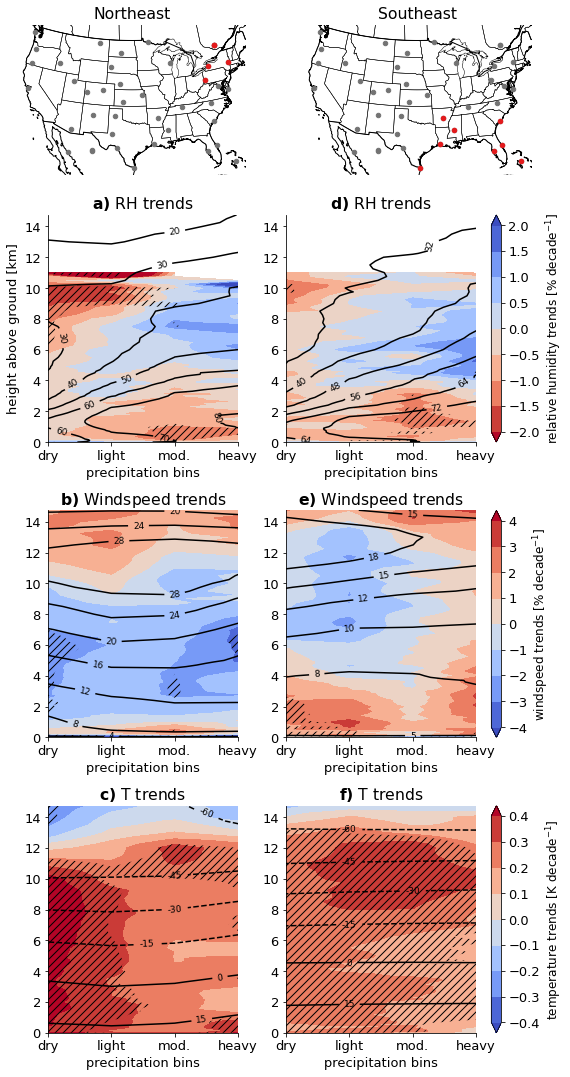

In [22]:
region_name = ['Midwest', 'Southeast', 'Northeast', 'West Coast']
region_extend = [[55, -85, 37 , -103],
                [35, -75, 25, -98],
                [55, -70, 40 , -85],
                [55, -117, 30 , -127]]

time_utc = ['0-UTC', '12-UTC', '0-and-12-UTC']
sel_reg = [2,1]
dt = 0
mo = 0


fig = plt.figure(figsize=(7,16))
rgsLableABC=list(string.ascii_lowercase)
plt.rcParams.update({'font.size': 13})
gs1 = gridspec.GridSpec(3, len(sel_reg))
gs1.update(left=0.05, right=0.90,
           bottom=0.1, top=0.81,
           wspace=0.25, hspace=0.3)

gs2 = gridspec.GridSpec(1, len(sel_reg))
gs2.update(left=-0.01, right=1.01,
           bottom=0.83, top=0.99,
           wspace=0.25, hspace=0.3)

for reg in range(len(sel_reg)):
    re = sel_reg[reg]
    stations = (Lat >= region_extend[re][2]) & (Lat <= region_extend[re][0]) & \
               (Lon >= region_extend[re][3]) & (Lon <= region_extend[re][1])
    print('stations '+str(np.sum(stations)))

#     # -------------------------
#     # MIXING RATIO
#     ax = plt.subplot(gs1[reg,0])
#     # plt.contourf(BinNames, Zcoord, rs_trends[:,:,UW_VARS.index('MR'),mo,st,0].T*10, 
#     #              cmap='coolwarm', levels = np.linspace(-10,10,21), extend='both')
#     cs = plt.contourf(BinNames, Zcoord/1000., np.nanmedian(rs_trends[dt,:,:,UW_VARS.index('MR'),mo,stations,0], axis=0).T*10, 
#                  cmap='coolwarm_r', levels = np.linspace(-5,5,21), extend='both')
#     plt.contourf(BinNames, Zcoord/1000., np.nanmedian(rs_trends[dt,:,:,UW_VARS.index('MR'),mo,stations,3], axis=0).T, 
#                  levels=[0,0.1, 1], hatches=['///', None], alpha=0)
#     CS = plt.contour(BinNames, Zcoord/1000., np.nanmedian(rs_binned[dt,:,:,:,UW_VARS.index('MR'),mo,stations], axis=(0,1)).T, 
#                 colors='k', )
#     ax.clabel(CS, fontsize=9, inline=True, fmt='%1.1f')
#     plt.title(r"$\bf{" + rgsLableABC[0+reg*4] + ")}$"+' MR trends')
#     ax.set_ylabel('height above ground [km]')
#     ax.set_xlabel('precipitation bins')
    
#     if reg == len(sel_reg)-1:
#         pos1 = ax.get_position()
#         CbarAx = axes([pos1.x0, pos1.y0-0.1, pos1.width, 0.02])
#         cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=np.linspace(0,0.0015,41))
#         # cb.ax.set_xticklabels(LEVS,rotation=90)
#         cb.set_label('mixing ratio trends [% decade$^{-1}$]', fontsize=12)


    # -------------------------
    # RELATIVE HUMIDITY
    ax = plt.subplot(gs1[0,reg])
    # plt.contourf(BinNames, Zcoord, rs_trends[:,:,UW_VARS.index('MR'),mo,st,0].T*10, 
    #              cmap='coolwarm', levels = np.linspace(-10,10,21), extend='both')
    RH_act = np.nanmedian(rs_trends[dt,:,:,VARS.index('RH'),mo,stations,0], axis=0).T*1000
    RH_sig = np.nanmedian(rs_trends[dt,:,:,VARS.index('RH'),mo,stations,3], axis=0).T
    if mo == 0:
        RH_act[Zcoord > 11000,:] = np.nan
        RH_sig[Zcoord > 11000,:] = np.nan
    cs = plt.contourf(BinNames, Zcoord/1000., RH_act, 
                 cmap='coolwarm_r', levels = np.linspace(-2,2,9), extend='both')
    plt.contourf(BinNames, Zcoord/1000., RH_sig, 
                 levels=[0,0.1, 1], hatches=['///', None], alpha=0)
    CS = plt.contour(BinNames, Zcoord/1000., np.nanmedian(rs_binned[dt,:,:,:,VARS.index('RH'),mo,stations], axis=(0,1)).T*100, 
                colors='k', )
    ax.clabel(CS, fontsize=9, inline=True, fmt='%1.0f')
    plt.title(r"$\bf{" + rgsLableABC[0+reg*3] + ")}$"+' RH trends')
    if reg == 0:
        ax.set_ylabel('height above ground [km]')
    ax.set_xlabel('precipitation bins')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    if reg == len(sel_reg)-1:
        pos1 = ax.get_position()
        CbarAx = axes([pos1.x0 + pos1.width+0.03, pos1.y0, 0.02, pos1.height])
        cb = colorbar(cs, cax = CbarAx, orientation='vertical', extend='both')#, ticks=np.linspace(0,0.0015,41))
        # cb.ax.set_xticklabels(LEVS,rotation=90)
        cb.set_label('relative humidity trends [% decade$^{-1}$]', fontsize=12)
    

    ax = plt.subplot(gs1[1,reg])
    cs = plt.contourf(BinNames, Zcoord/1000., np.nanmedian(rs_trends[dt,:,:,UW_VARS.index('WSPD'),mo,stations,0], axis=0).T*10, 
                 cmap='coolwarm', levels = np.linspace(-4,4,9), extend='both')
    plt.contourf(BinNames, Zcoord/1000., np.nanmedian(rs_trends[dt,:,:,UW_VARS.index('WSPD'),mo,stations,3], axis=0).T, 
                 levels=[0,0.1, 1], hatches=['///', None], alpha=0)
    CS = plt.contour(BinNames, Zcoord/1000., np.nanmedian(rs_binned[dt,:,:,:,UW_VARS.index('WSPD'),mo,stations], axis=(0,1)).T, 
                colors='k', )
    ax.clabel(CS, fontsize=9, inline=True, fmt='%1.0f')
    plt.title(r"$\bf{" + rgsLableABC[1+reg*3] + ")}$"+' Windspeed trends')
    ax.set_xlabel('precipitation bins')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    if reg == len(sel_reg)-1:
        pos1 = ax.get_position()
        CbarAx = axes([pos1.x0 + pos1.width+0.03, pos1.y0, 0.02, pos1.height])
        cb = colorbar(cs, cax = CbarAx, orientation='vertical', extend='both')#, ticks=np.linspace(0,0.0015,41))
        # cb.ax.set_xticklabels(LEVS,rotation=90)
        cb.set_label('windspeed trends [% decade$^{-1}$]', fontsize=12)


    ax = plt.subplot(gs1[2,reg])
    cs = plt.contourf(BinNames, Zcoord/1000., np.nanmedian(rs_trends[dt,:,:,UW_VARS.index('T'),mo,stations,0], axis=0).T*10, 
                 cmap='coolwarm', levels = np.linspace(-0.4,0.4,9), extend='both')
    plt.contourf(BinNames, Zcoord/1000., np.nanmedian(rs_trends[dt,:,:,UW_VARS.index('T'),mo,stations,3], axis=0).T, 
                 levels=[0,0.1, 1], hatches=['///', None], alpha=0)
    CS = plt.contour(BinNames, Zcoord/1000., np.nanmedian(rs_binned[dt,:,:,:,UW_VARS.index('T'),mo,stations], axis=(0,1)).T, 
                colors='k', )
    ax.clabel(CS, fontsize=9, inline=True, fmt='%1.0f')
    plt.title(r"$\bf{" + rgsLableABC[2+reg*3] + ")}$"+' T trends')
    ax.set_xlabel('precipitation bins')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    if reg == len(sel_reg)-1:
        pos1 = ax.get_position()
        CbarAx = axes([pos1.x0 + pos1.width+0.03, pos1.y0, 0.02, pos1.height])
        cb = colorbar(cs, cax = CbarAx, orientation='vertical', extend='both')#, ticks=np.linspace(0,0.0015,41))
        # cb.ax.set_xticklabels(LEVS,rotation=90)
        cb.set_label('temperature trends [K decade$^{-1}$]', fontsize=12)
#         cb.ax.tick_params(rotation=90)

    

    # ==================================
    # Show location of sounding sites
    ax = plt.subplot(gs2[0,reg], projection=cart_proj)
    plt.axis('off')
    
    plt.title(region_name[re])
    
    rs_foc = (Lon < -70)
    ax.coastlines()
    ax.add_feature(cf.BORDERS)
    ax.add_feature(cf.STATES, lw=0.5)
    cs = plt.scatter(Lon[rs_foc], Lat[rs_foc], c='#737373', transform=ccrs.PlateCarree(),s=20, zorder=10)
    cs = plt.scatter(Lon[stations], Lat[stations], c='#e41a1c', transform=ccrs.PlateCarree(),s=20, zorder=11)

    
sPlotFile=''
sPlotName= 'Radiosonde-Sounding_changes_'+time_utc[dt]+'_'+DATASETS[mo]+'_paper.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName, bbox_inches='tight') #, dpi=700)

stations 5
stations 8
stations 7
stations 3
 
stations 4
 
stations 5
        Plot map to: Radiosonde-Sounding_changes_12-UTC_CONUS404.pdf


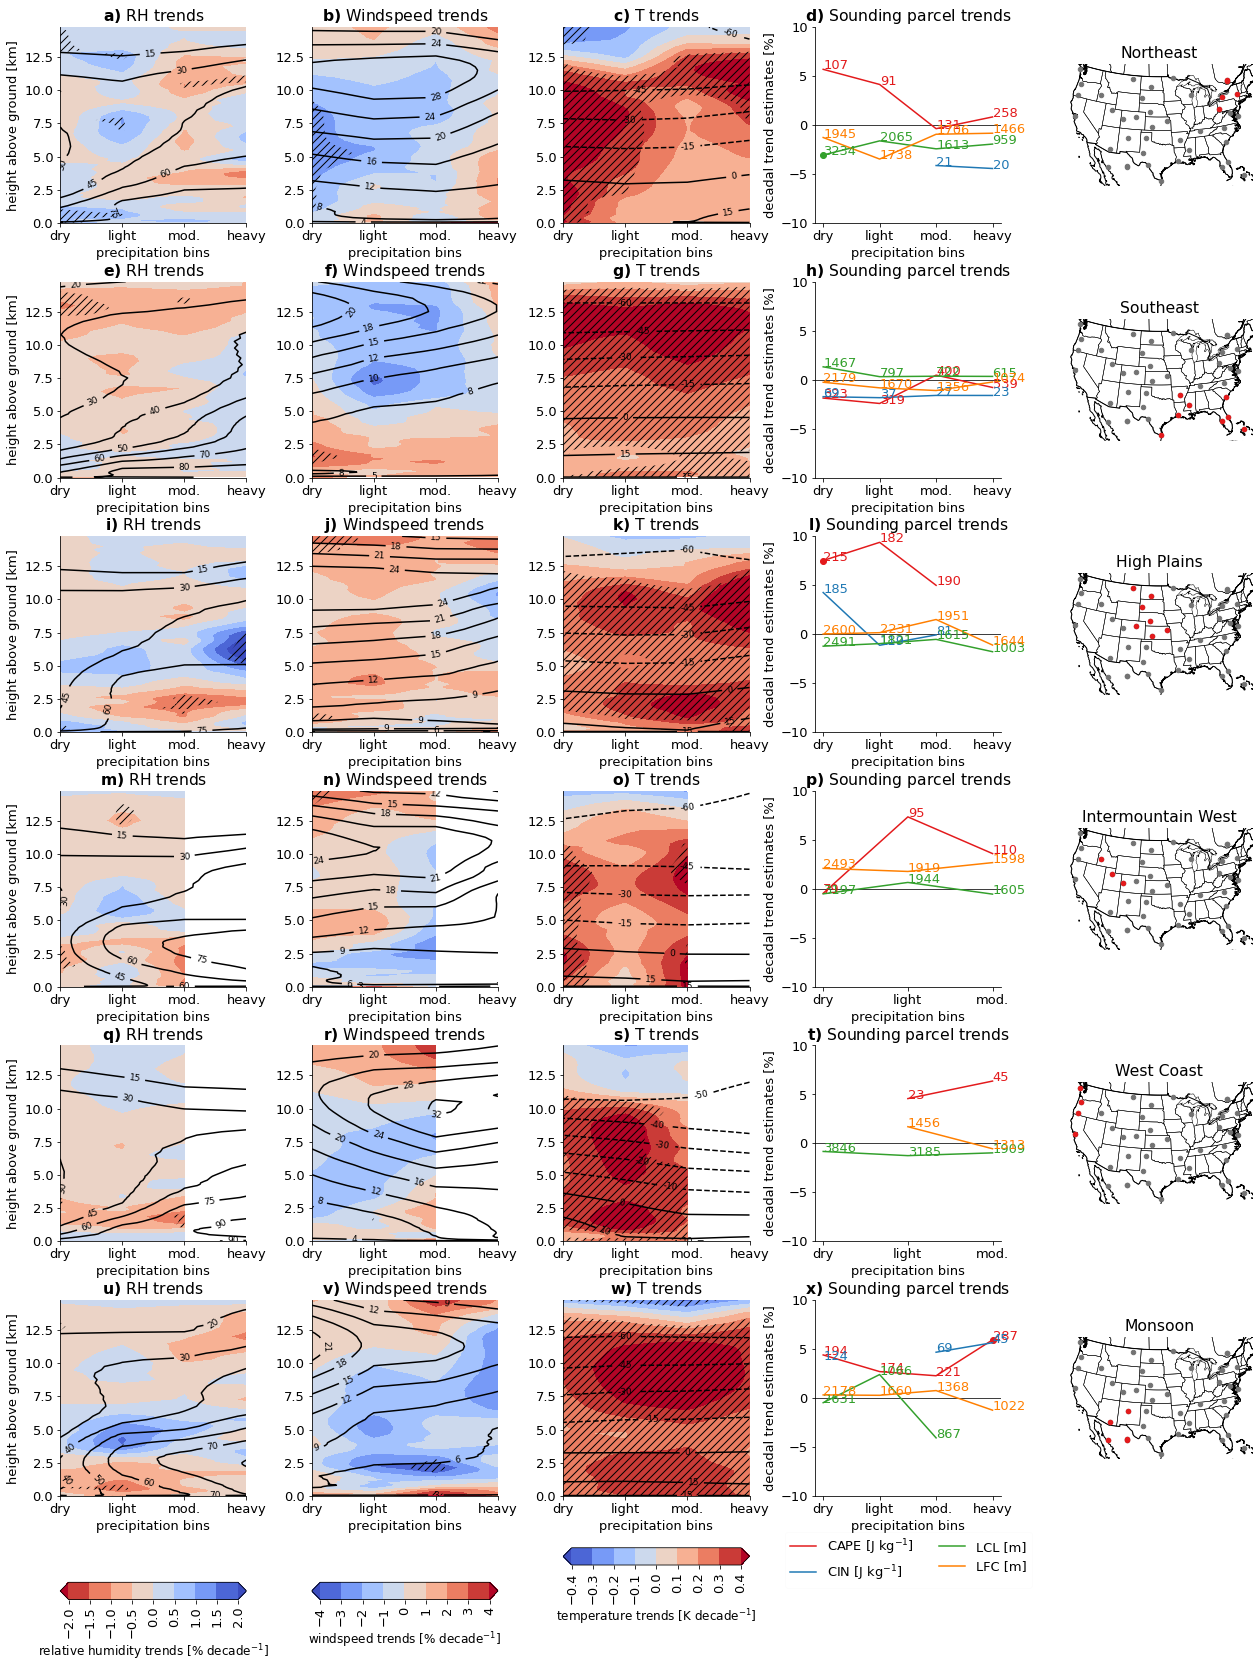

In [26]:
region_name = ['High Plains', 'Southeast', 'Northeast', 'Intermountain West', 'West Coast','Monsoon']
region_extend = [[55, -94, 37 , -107],
                [35, -75, 25, -98],
                [55, -70, 40 , -85],
                [45, -105, 38 , -117],
                [55, -117, 30 , -127],
                [38, -105, 25 , -117]]

time_utc = ['0-UTC', '12-UTC', '0-and-12-UTC']
sel_reg = [2,1,0,3,4,5]
dt = 1
mo = 1


fig = plt.figure(figsize=(18,4*len(sel_reg)))
rgsLableABC=list(string.ascii_lowercase)
plt.rcParams.update({'font.size': 13})
gs1 = gridspec.GridSpec(len(sel_reg),5)
gs1.update(left=0.05, right=0.97,
           bottom=0.05, top=0.9,
           wspace=0.35, hspace=0.3)

for reg in range(len(sel_reg)):
    re = sel_reg[reg]
    stations = (Lat >= region_extend[re][2]) & (Lat <= region_extend[re][0]) & \
               (Lon >= region_extend[re][3]) & (Lon <= region_extend[re][1])
    print('stations '+str(np.sum(stations)))

#     # -------------------------
#     # MIXING RATIO
#     ax = plt.subplot(gs1[reg,0])
#     # plt.contourf(BinNames, Zcoord, rs_trends[:,:,UW_VARS.index('MR'),mo,st,0].T*10, 
#     #              cmap='coolwarm', levels = np.linspace(-10,10,21), extend='both')
#     cs = plt.contourf(BinNames, Zcoord/1000., np.nanmedian(rs_trends[dt,:,:,UW_VARS.index('MR'),mo,stations,0], axis=0).T*10, 
#                  cmap='coolwarm_r', levels = np.linspace(-5,5,21), extend='both')
#     plt.contourf(BinNames, Zcoord/1000., np.nanmedian(rs_trends[dt,:,:,UW_VARS.index('MR'),mo,stations,3], axis=0).T, 
#                  levels=[0,0.1, 1], hatches=['///', None], alpha=0)
#     CS = plt.contour(BinNames, Zcoord/1000., np.nanmedian(rs_binned[dt,:,:,:,UW_VARS.index('MR'),mo,stations], axis=(0,1)).T, 
#                 colors='k', )
#     ax.clabel(CS, fontsize=9, inline=True, fmt='%1.1f')
#     plt.title(r"$\bf{" + rgsLableABC[0+reg*4] + ")}$"+' MR trends')
#     ax.set_ylabel('height above ground [km]')
#     ax.set_xlabel('precipitation bins')
    
#     if reg == len(sel_reg)-1:
#         pos1 = ax.get_position()
#         CbarAx = axes([pos1.x0, pos1.y0-0.1, pos1.width, 0.02])
#         cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=np.linspace(0,0.0015,41))
#         # cb.ax.set_xticklabels(LEVS,rotation=90)
#         cb.set_label('mixing ratio trends [% decade$^{-1}$]', fontsize=12)


    # -------------------------
    # RELATIVE HUMIDITY
    ax = plt.subplot(gs1[reg,0])
    # plt.contourf(BinNames, Zcoord, rs_trends[:,:,UW_VARS.index('MR'),mo,st,0].T*10, 
    #              cmap='coolwarm', levels = np.linspace(-10,10,21), extend='both')
    RH_act = np.nanmedian(rs_trends[dt,:,:,VARS.index('RH'),mo,stations,0], axis=0).T*1000
    RH_sig = np.nanmedian(rs_trends[dt,:,:,VARS.index('RH'),mo,stations,3], axis=0).T
    if mo == 0:
        RH_act[Zcoord > 11000,:] = np.nan
        RH_sig[Zcoord > 11000,:] = np.nan
    cs = plt.contourf(BinNames, Zcoord/1000., RH_act, 
                 cmap='coolwarm_r', levels = np.linspace(-2,2,9), extend='both')
    plt.contourf(BinNames, Zcoord/1000., RH_sig, 
                 levels=[0,0.1, 1], hatches=['///', None], alpha=0)
    CS = plt.contour(BinNames, Zcoord/1000., np.nanmedian(rs_binned[dt,:,:,:,VARS.index('RH'),mo,stations], axis=(0,1)).T*100, 
                colors='k', )
    ax.clabel(CS, fontsize=9, inline=True, fmt='%1.0f')
    plt.title(r"$\bf{" + rgsLableABC[0+reg*4] + ")}$"+' RH trends')
    ax.set_ylabel('height above ground [km]')
    ax.set_xlabel('precipitation bins')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    if reg == len(sel_reg)-1:
        pos1 = ax.get_position()
        CbarAx = axes([pos1.x0, pos1.y0-0.06, pos1.width, 0.01])
        cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=np.linspace(0,0.0015,41))
        # cb.ax.set_xticklabels(LEVS,rotation=90)
        cb.set_label('relative humidity trends [% decade$^{-1}$]', fontsize=12)
        cb.ax.tick_params(rotation=90)
    

    ax = plt.subplot(gs1[reg,1])
    cs = plt.contourf(BinNames, Zcoord/1000., np.nanmedian(rs_trends[dt,:,:,UW_VARS.index('WSPD'),mo,stations,0], axis=0).T*10, 
                 cmap='coolwarm', levels = np.linspace(-4,4,9), extend='both')
    plt.contourf(BinNames, Zcoord/1000., np.nanmedian(rs_trends[dt,:,:,UW_VARS.index('WSPD'),mo,stations,3], axis=0).T, 
                 levels=[0,0.1, 1], hatches=['///', None], alpha=0)
    CS = plt.contour(BinNames, Zcoord/1000., np.nanmedian(rs_binned[dt,:,:,:,UW_VARS.index('WSPD'),mo,stations], axis=(0,1)).T, 
                colors='k', )
    ax.clabel(CS, fontsize=9, inline=True, fmt='%1.0f')
    plt.title(r"$\bf{" + rgsLableABC[1+reg*4] + ")}$"+' Windspeed trends')
    ax.set_xlabel('precipitation bins')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    if reg == len(sel_reg)-1:
        pos1 = ax.get_position()
        CbarAx = axes([pos1.x0, pos1.y0-0.06, pos1.width, 0.01])
        cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=np.linspace(0,0.0015,41))
        # cb.ax.set_xticklabels(LEVS,rotation=90)
        cb.set_label('windspeed trends [% decade$^{-1}$]', fontsize=12)
        cb.ax.tick_params(rotation=90)


    ax = plt.subplot(gs1[reg,2])
    cs = plt.contourf(BinNames, Zcoord/1000., np.nanmedian(rs_trends[dt,:,:,UW_VARS.index('T'),mo,stations,0], axis=0).T*10, 
                 cmap='coolwarm', levels = np.linspace(-0.4,0.4,9), extend='both')
    plt.contourf(BinNames, Zcoord/1000., np.nanmedian(rs_trends[dt,:,:,UW_VARS.index('T'),mo,stations,3], axis=0).T, 
                 levels=[0,0.1, 1], hatches=['///', None], alpha=0)
    CS = plt.contour(BinNames, Zcoord/1000., np.nanmedian(rs_binned[dt,:,:,:,UW_VARS.index('T'),mo,stations], axis=(0,1)).T, 
                colors='k', )
    ax.clabel(CS, fontsize=9, inline=True, fmt='%1.0f')
    plt.title(r"$\bf{" + rgsLableABC[2+reg*4] + ")}$"+' T trends')
    ax.set_xlabel('precipitation bins')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    if reg == len(sel_reg)-1:
        pos1 = ax.get_position()
        CbarAx = axes([pos1.x0, pos1.y0-0.04, pos1.width, 0.01])
        cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=np.linspace(0,0.0015,41))
        # cb.ax.set_xticklabels(LEVS,rotation=90)
        cb.set_label('temperature trends [K decade$^{-1}$]', fontsize=12)
        cb.ax.tick_params(rotation=90)

    

    # ============================================
    # ---- TRENDS IN PARCEL SOUNDING INDICES -----
    ax = plt.subplot(gs1[reg,3])
    plt.axhline(y=0, color='k', linestyle='-', lw=0.75)

    # CAPE
    plt.plot(BinNames, np.nanmean(parcel_trends[dt,:,mo,stations,0,0], axis=0)*10, c='#e31a1c', label='CAPE [J kg$^{-1}$]')
    SIG = np.nanmean(parcel_trends[dt,:,mo,stations,0,3], axis=0) <= 0.1
    plt.scatter(np.array(range(len(BinNames)))[SIG], np.nanmean(parcel_trends[dt,:,mo,stations,0,0], axis=0)[SIG]*10, c='#e31a1c')
    ii = 0
    try:
        for i,j in zip(np.array(range(len(BinNames))), np.nanmean(parcel_trends[dt,:,mo,stations,0,0], axis=0)*10):
            ax.annotate(str(int(np.nanmean(parcel_binned[dt,:,ii,mo,stations,0], axis=(0,1)))),xy=(i,j), color='#e31a1c')
            ii = ii+1
    except:
        print(' ')

    # CIN
    plt.plot(BinNames, np.nanmean(parcel_trends[dt,:,mo,stations,1,0], axis=0)*10, c='#1f78b4', label='CIN [J kg$^{-1}$]')
    SIG = np.nanmean(parcel_trends[dt,:,mo,stations,1,3], axis=0) <= 0.1
    plt.scatter(np.array(range(len(BinNames)))[SIG], np.nanmean(parcel_trends[dt,:,mo,stations,1,0], axis=0)[SIG]*10, c='#1f78b4')
    ii = 0
    try:
        for i,j in zip(np.array(range(len(BinNames))), np.nanmean(parcel_trends[dt,:,mo,stations,1,0], axis=0)*10):
            ax.annotate(str(int(np.nanmean(parcel_binned[dt,:,ii,mo,stations,1], axis=(0,1)))),xy=(i,j), color='#1f78b4')
            ii = ii+1
    except:
        print(' ')

    # LCL
    plt.plot(BinNames, np.nanmean(parcel_trends[dt,:,mo,stations,2,0], axis=0)*10, c='#33a02c', label='LCL [m]')
    SIG = np.nanmean(parcel_trends[dt,:,mo,stations,2,3], axis=0) <= 0.1
    plt.scatter(np.array(range(len(BinNames)))[SIG], np.nanmean(parcel_trends[dt,:,mo,stations,2,0], axis=0)[SIG]*10, c='#33a02c')
    ii = 0
    for i,j in zip(np.array(range(len(BinNames))), np.nanmean(parcel_trends[dt,:,mo,stations,2,0], axis=0)*10):
        try:
            ax.annotate(str(int(np.nanmean(parcel_binned[dt,:,ii,mo,stations,2], axis=(0,1)))),xy=(i,j), color='#33a02c')
        except:
            continue
        ii = ii+1

    # LFC
    plt.plot(BinNames, np.nanmean(parcel_trends[dt,:,mo,stations,3,0], axis=0)*10, c='#ff7f00', label='LFC [m]')
    SIG = np.nanmean(parcel_trends[dt,:,mo,stations,3,3], axis=0) <= 0.1
    plt.scatter(np.array(range(len(BinNames)))[SIG], np.nanmean(parcel_trends[dt,:,mo,stations,3,0], axis=0)[SIG]*10, c='#ff7f00')
    ii = 0
    for i,j in zip(np.array(range(len(BinNames))), np.nanmean(parcel_trends[dt,:,mo,stations,3,0], axis=0)*10):
        try:
            ax.annotate(str(int(np.nanmean(parcel_binned[dt,:,ii,mo,stations,3], axis=(0,1)))),xy=(i,j), color='#ff7f00')
        except:
            continue
        ii = ii+1

    plt.title(r"$\bf{" + rgsLableABC[3+reg*4] + ")}$"+' Sounding parcel trends')
    ax.set_ylabel('decadal trend estimates [%]')
    ax.set_xlabel('precipitation bins')
    if reg == len(sel_reg)-1:
        legend = plt.legend(ncol=2, framealpha=0.05, bbox_to_anchor=(1.2, -0.15))
    plt.ylim(-10,10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # ==================================
    # Show location of sounding sites
    ax = plt.subplot(gs1[reg,4], projection=cart_proj)
    plt.axis('off')
    
    plt.title(region_name[re])
    
    rs_foc = (Lon < -70)
    ax.coastlines()
    ax.add_feature(cf.BORDERS)
    ax.add_feature(cf.STATES, lw=0.5)
    cs = plt.scatter(Lon[rs_foc], Lat[rs_foc], c='#737373', transform=ccrs.PlateCarree(),s=20, zorder=10)
    cs = plt.scatter(Lon[stations], Lat[stations], c='#e41a1c', transform=ccrs.PlateCarree(),s=20, zorder=11)

    
sPlotFile=''
sPlotName= 'Radiosonde-Sounding_changes_'+time_utc[dt]+'_'+DATASETS[mo]+'.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName, bbox_inches='tight') #, dpi=700)

### Only show temperature changes for all regions